# Advanced Lane Finding

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## Step1: Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

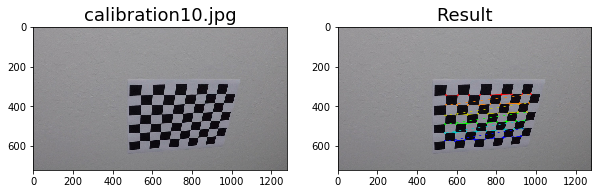

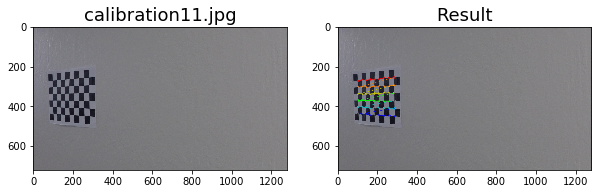

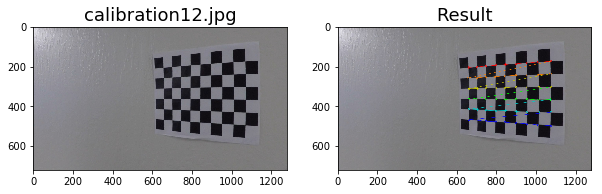

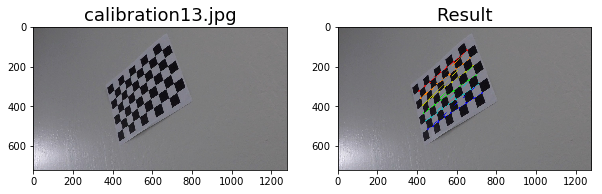

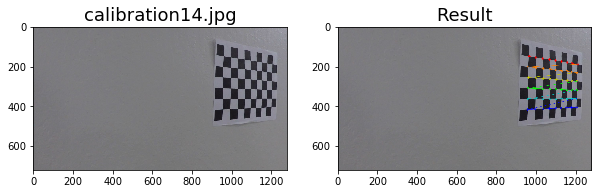

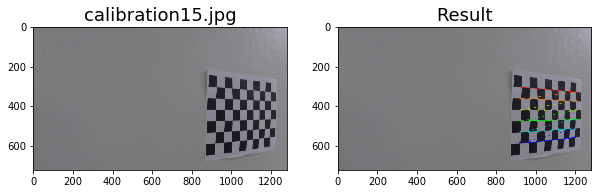

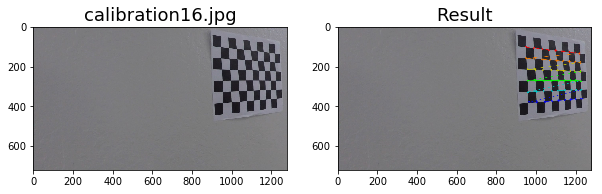

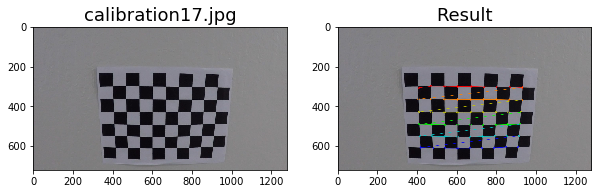

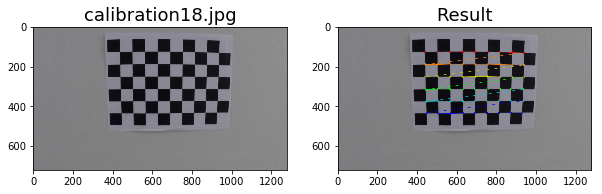

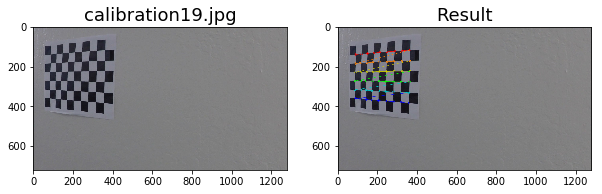

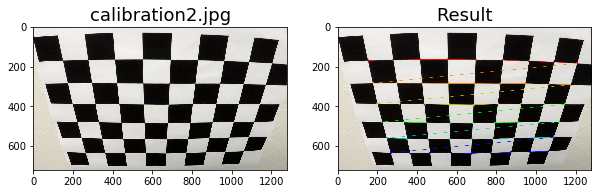

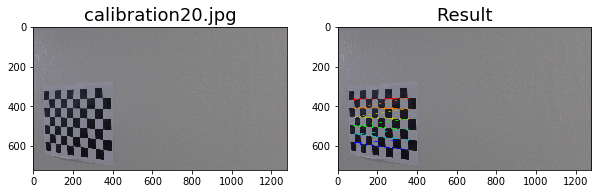

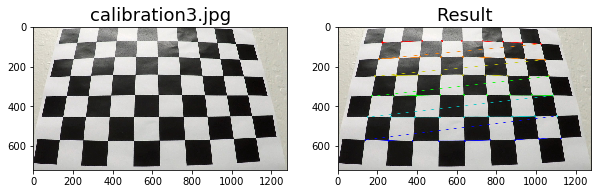

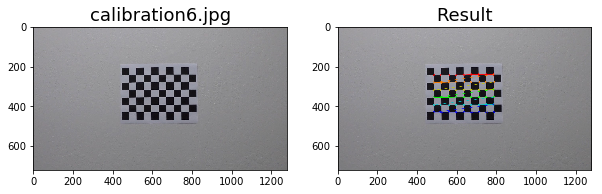

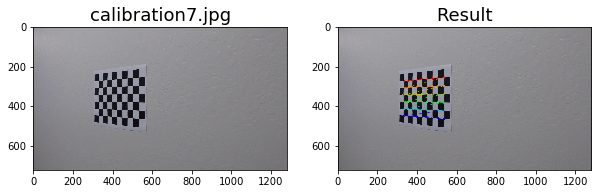

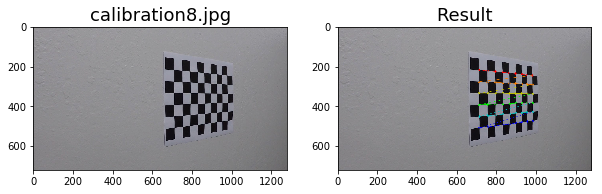

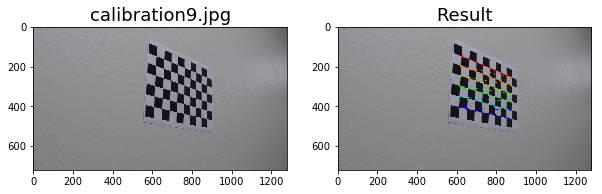

In [2]:
import os

# prepare object points
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        ax1.imshow(mpimg.imread(fname))
        ax1.set_title(os.path.basename(fname), fontsize=18)
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax2.set_title('Result', fontsize=18)


In [3]:
# Do camera calibration given object points and image points
# img_size = (img.shape[1], img.shape[0])
img_size = (1280, 720)
C_ret, C_mtx, C_dist, C_rvecs, C_tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None,None)

## Step2: Apply a distortion correction to raw images.

In [4]:
def undistort(img):

    dst = cv2.undistort(img, C_mtx, C_dist, None, C_mtx)

    return dst

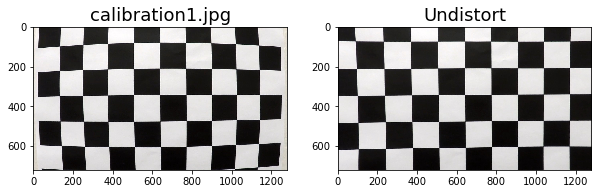

In [5]:
images = glob.glob('camera_cal/calibration1.jpg')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    dst = undistort(img)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.imshow(mpimg.imread(fname))
    ax1.set_title(os.path.basename(fname), fontsize=18)
    ax2.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
    ax2.set_title('Undistort', fontsize=18)

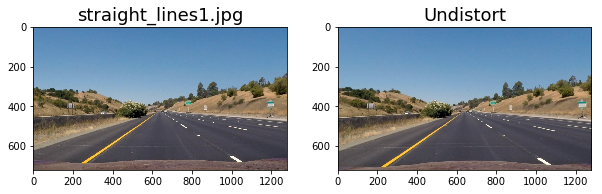

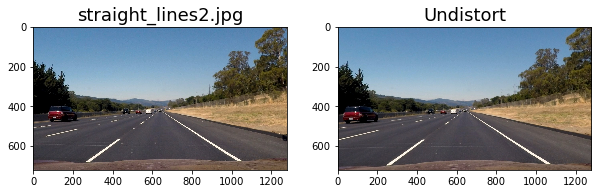

In [6]:
images = glob.glob('test_images/straight_lines*.jpg')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    dst = undistort(img)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.imshow(mpimg.imread(fname))
    ax1.set_title(os.path.basename(fname), fontsize=18)
    ax2.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
    ax2.set_title('Undistort', fontsize=18)

## Step3: Use color transforms, gradients, etc., to create a thresholded binary image.

In [7]:
def create_bin_image(img):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20 + 10
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return color_binary, combined_binary

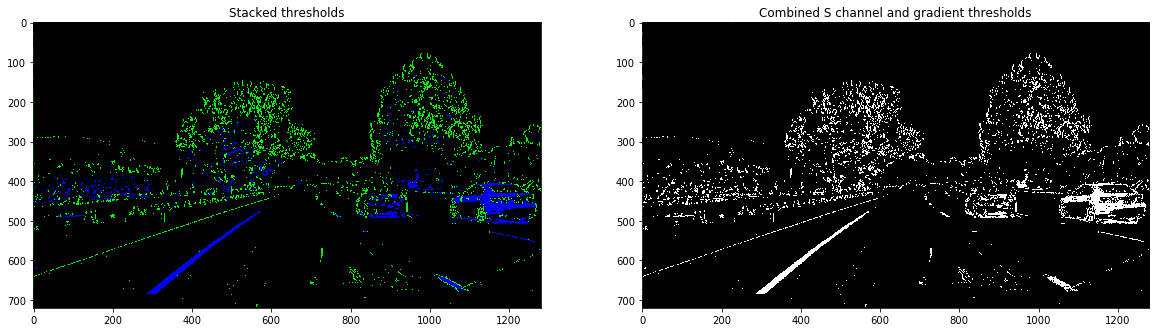

In [8]:
img = mpimg.imread('test_images/test1.jpg')
color_img, combined_img = create_bin_image(img)

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_img)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_img, cmap='gray')

## Step4: Apply a perspective transform to rectify binary image ("birds-eye view").

In [9]:
# Perform perspective transform
def birds_eye(img):
    undist = undistort(img) 
    img_size = (undist.shape[1], undist.shape[0])
    
    # For source points I'm grabbing the outer four detected corners
    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    dst = np.float32(
        [[(img_size[0] / 4) + 50, 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4) - 50, 0]])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, img_size)

    return warped, M, M_inv

In [10]:
def processing(img):
    color_img, combined_img = create_bin_image(img)
    warped_img, M, M_inv = birds_eye(combined_img)
    
    return warped_img, M, M_inv

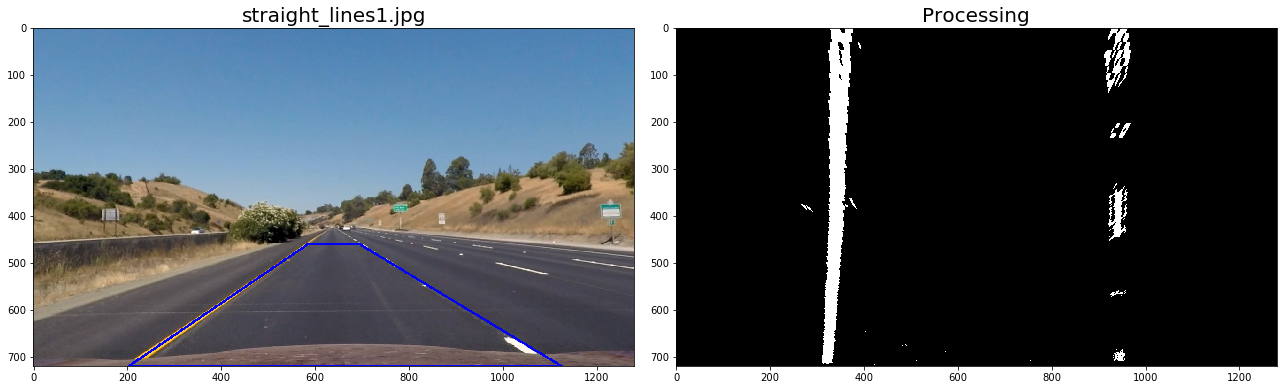

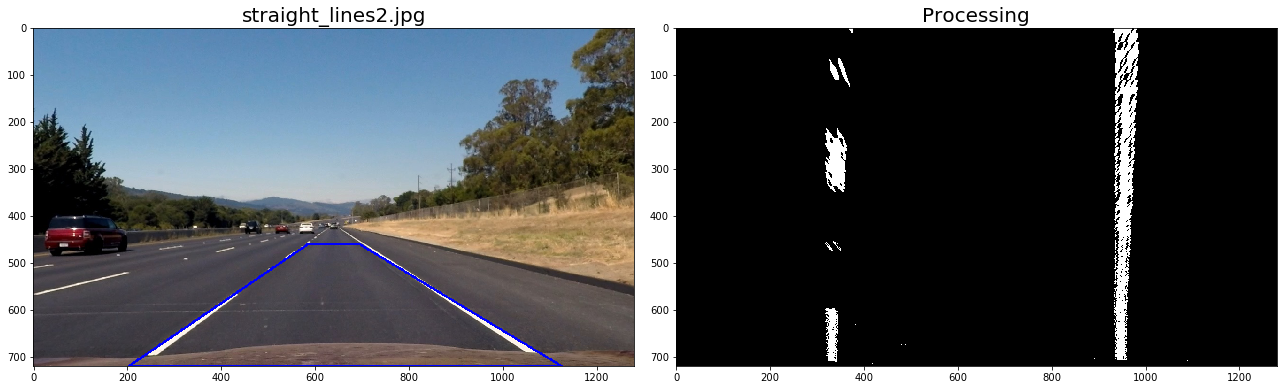

In [11]:
images = glob.glob('test_images/straight_lines*.jpg')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    
    undist_img = undistort(img)

    img_size = (undist_img.shape[1], undist_img.shape[0])
    pts = np.array([[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]], np.int32)
    pts = pts.reshape((-1,1,2))
    cv2.polylines(undist_img, [pts],True,(255,0,0), thickness=3)
    
    process_img, M, M_inv = processing(img)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 12))
    f.tight_layout()
    ax1.imshow(cv2.cvtColor(undist_img, cv2.COLOR_BGR2RGB))
    ax1.set_title(os.path.basename(fname), fontsize=20)  
    ax2.imshow(process_img, cmap='gray')
    ax2.set_title('Processing', fontsize=20)
    

## Step5: Detect lane pixels and fit to find the lane boundary.

In [12]:
# Assuming you have created a warped binary image called "binary_warped"

def detect_lane(img):
    binary_warped = img

    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    
    return left_fit, right_fit, ploty, left_fitx, right_fitx, out_img

(720, 0)

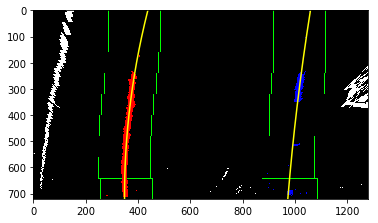

In [13]:
# Visualization
img = mpimg.imread('test_images/test1.jpg')
binary_warped, M, M_inv = processing(img)
left_fit, right_fit, ploty, left_fitx, right_fitx, out_img = detect_lane(binary_warped)

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [14]:
def find_lane_in_margin(img, left_fit, right_fit):
    binary_warped = img
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return left_fit, right_fit, ploty, left_fitx, right_fitx, result

(720, 0)

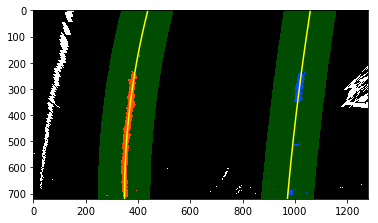

In [15]:
# Visualization

left_fit, right_fit, ploty, left_fitx, right_fitx, result = find_lane_in_margin(binary_warped, left_fit, right_fit)

plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


## Step6: Determine the curvature of the lane and vehicle position with respect to center.

In [16]:
def getCurvature(ploty, leftx, rightx):
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters

    
    return left_curverad, right_curverad

In [17]:
left_curverad, right_curverad = getCurvature(ploty, left_fitx, right_fitx)
print(left_curverad, 'm', right_curverad, 'm')

922.546515156 m 3508.41872352 m


In [18]:
def getPosition_Offset(leftx, rightx):
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    position = (leftx[-1] + rightx[-1]) / 2
    center = 1280/2
    offset_pix = position - center
    offset_m = xm_per_pix * offset_pix
    
    return offset_m

In [19]:
offset = getPosition_Offset(left_fitx, right_fitx)
print(offset, 'm')

0.106419196562 m


## Step7: Warp the detected lane boundaries back onto the original image.

In [20]:
def find_lane_pipeline(img):
    undist = undistort(img)
    
    warped, M, M_inv = processing(img)
    
    left_fit, right_fit, ploty, left_fitx, right_fitx, out_img = detect_lane(warped)
    
    left_curverad, right_curverad = getCurvature(ploty, left_fitx, right_fitx)
    curverad = int((left_curverad + right_curverad)/2)
    
    offset = getPosition_Offset(left_fitx, right_fitx)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)  
    
    return result, curverad, offset

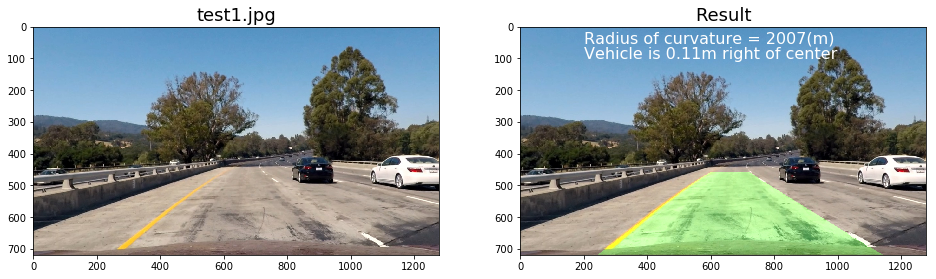

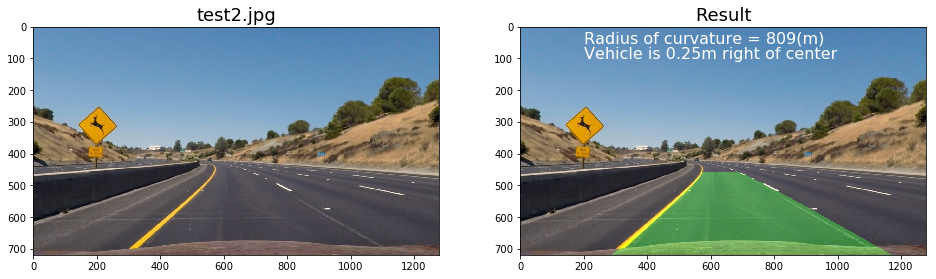

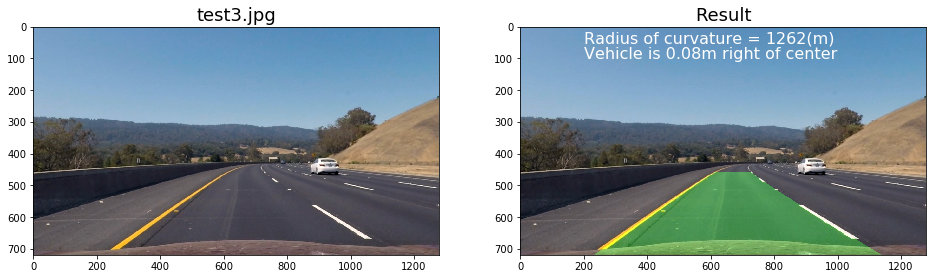

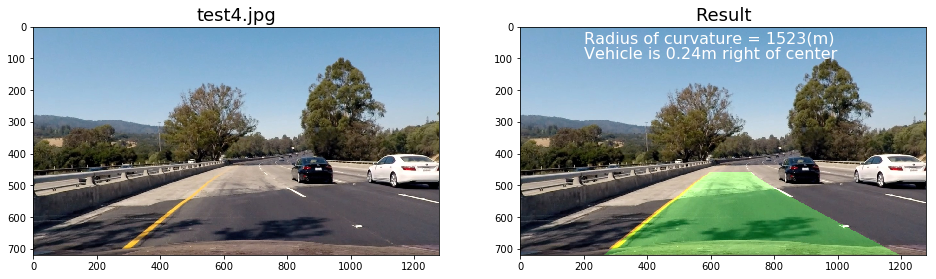

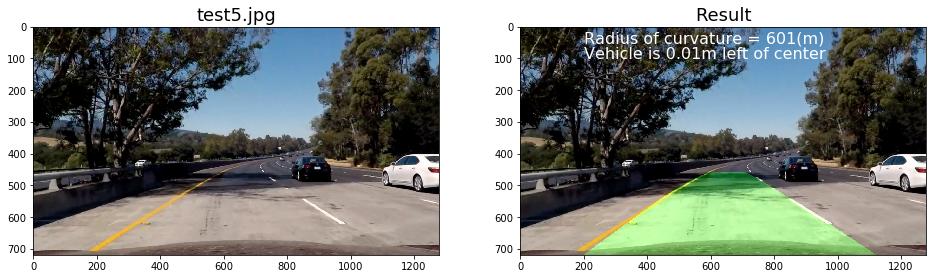

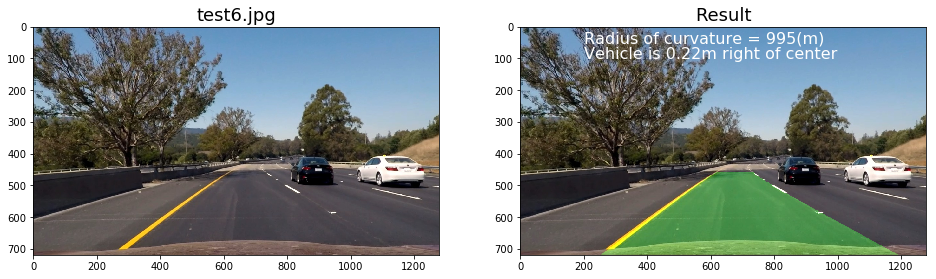

In [21]:
images = glob.glob('test_images/test*.jpg')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    undist = undistort(img)
    
    result, curverad, offset = find_lane_pipeline(img)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
    ax1.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
    ax1.set_title(os.path.basename(fname), fontsize=18)
    ax2.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    ax2.text(200, 50, 'Radius of curvature = {}(m)'.format(curverad), color='white', fontsize=16)
    
    if offset > 0:
        ax2.text(200, 100, 'Vehicle is {:.2f}m right of center'.format(offset), color='white', fontsize=16)
    else:
        ax2.text(200, 100, 'Vehicle is {:.2f}m left of center'.format(-offset), color='white', fontsize=16)
    
    ax2.set_title('Result', fontsize=18)

## Step8: Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [22]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = 0 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
        
        self.count = 0
        self.err_count = 0
        self.left_fit = None
        self.right_fit = None
        self.ploty = None
        self.left_fitx = None
        self.right_fitx = None
        self.left_fitx_recent = []
        self.right_fitx_recent = []
        self.diff_pos = 0


In [ ]:
# Video Processing Pipeline
def process_vid(img):
    undist = undistort(img)
    warped, M, M_inv = processing(img)
    
    if Lane.detected is False:
        left_fit, right_fit, ploty, left_fitx, right_fitx, out_img = detect_lane(warped)      
    else:
        left_fit, right_fit, ploty, left_fitx, right_fitx, result = find_lane_in_margin(warped, Lane.left_fit, Lane.right_fit)
            
    
    # Check parallelism
    isParallel = True
    diff_arr = np.subtract(right_fitx, left_fitx)
    diff_arr_avg = np.average(diff_arr)
    for x in np.nditer(diff_arr):
        if abs(x - diff_arr_avg) > 100:
            isParallel = False
            break
    
    # Get Curvature
    left_curverad, right_curverad = getCurvature(ploty, left_fitx, right_fitx) 
    curverad = int((left_curverad + right_curverad)/2)
    
    # Get Vehivle position
    offset = getPosition_Offset(left_fitx, right_fitx)
    Lane.diff_pos = abs(offset - Lane.line_base_pos)
    
    isErr = False
    
    # Force calculate first 5 images
    if Lane.count < 5:
        Lane.detected = True
        Lane.ploty = ploty
    else:
        # Check lane is parallel, curvature is reasonable and compare with previous result
        if not isParallel or curverad > 10000 or curverad < 100 or abs(left_curverad - right_curverad) > 5000 or abs(Lane.radius_of_curvature - curverad) > 2500 or Lane.diff_pos > 0.5:
            Lane.err_count += 1
            isErr = True
            # Accumulate 3 errors then detect lane again
            if Lane.err_count > 3:
                Lane.detected = False
                Lane.err_count = 0
        else:
            Lane.ploty = ploty
            Lane.detected = True
            
    
    if Lane.detected is True and isErr is False:
        Lane.left_fit = left_fit
        Lane.right_fit = right_fit
        
        Lane.left_fitx_recent.append(left_fitx)
        Lane.right_fitx_recent.append(right_fitx)

        if len(Lane.left_fitx_recent) > 5:
            del Lane.left_fitx_recent[0]

        if len(Lane.right_fitx_recent) > 5:
            del Lane.right_fitx_recent[0]

        # average 5 frames
        Lane.left_fitx = np.mean(Lane.left_fitx_recent, axis=0)
        Lane.right_fitx = np.mean(Lane.right_fitx_recent, axis=0) 

        # Only update text every 5 frames to prevent text keep changing
        if Lane.count % 5 == 0:
            Lane.radius_of_curvature = curverad;
            Lane.line_base_pos = offset
                
    
    Lane.count += 1

    
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([Lane.left_fitx, Lane.ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([Lane.right_fitx, Lane.ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    cv2.putText(result, 'Radius of curvature = {}(m)'.format(Lane.radius_of_curvature), (200, 50), 
                fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    
    if offset > 0:
        cv2.putText(result, 'Vehicle is {:.2f}m right of center'.format(Lane.line_base_pos), (200, 100), 
                fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    else:
        cv2.putText(result, 'Vehicle is {:.2f}m left of center'.format(-Lane.line_base_pos), (200, 100), 
                fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    
    cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    
    return result

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Lane = Line()

output = 'project_video_output.mp4'

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("project_video.mp4").subclip(0,1)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_vid) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)


MoviePy: building video file project_video_output.mp4
----------------------------------------

Writing video into project_video_output.mp4
|########--| 1065/1210  88% [elapsed: 02:00 left: 00:16,  8.85 iters/sec]